## Is our base ACCESS-OM2 simulation in equilibrium?

Although we have initiated flux forced simulations from the 100th year of base ACCESS-OM2 simulation, we still have uncertainty on whether the base run is equilibriated or not. For that reason, we extend our base control run for another 60 years and check how far they have diverged from the first 100 years.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45927,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45669,Total threads: 4
Dashboard: /proxy/46727/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41089,


In [2]:
db = '/g/data/x77/db6174/access-om2/archive/databases/cc_database_param_kpp3.db'
session1 = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session2 = cc.database.create_session(db)

session = [session1, session2]
name = ['First 100 years', 'Next 100 years']
expt = ['025deg_jra55_ryf_param_kpp3', '025deg_jra55_ryf_param_kpp_extended2']

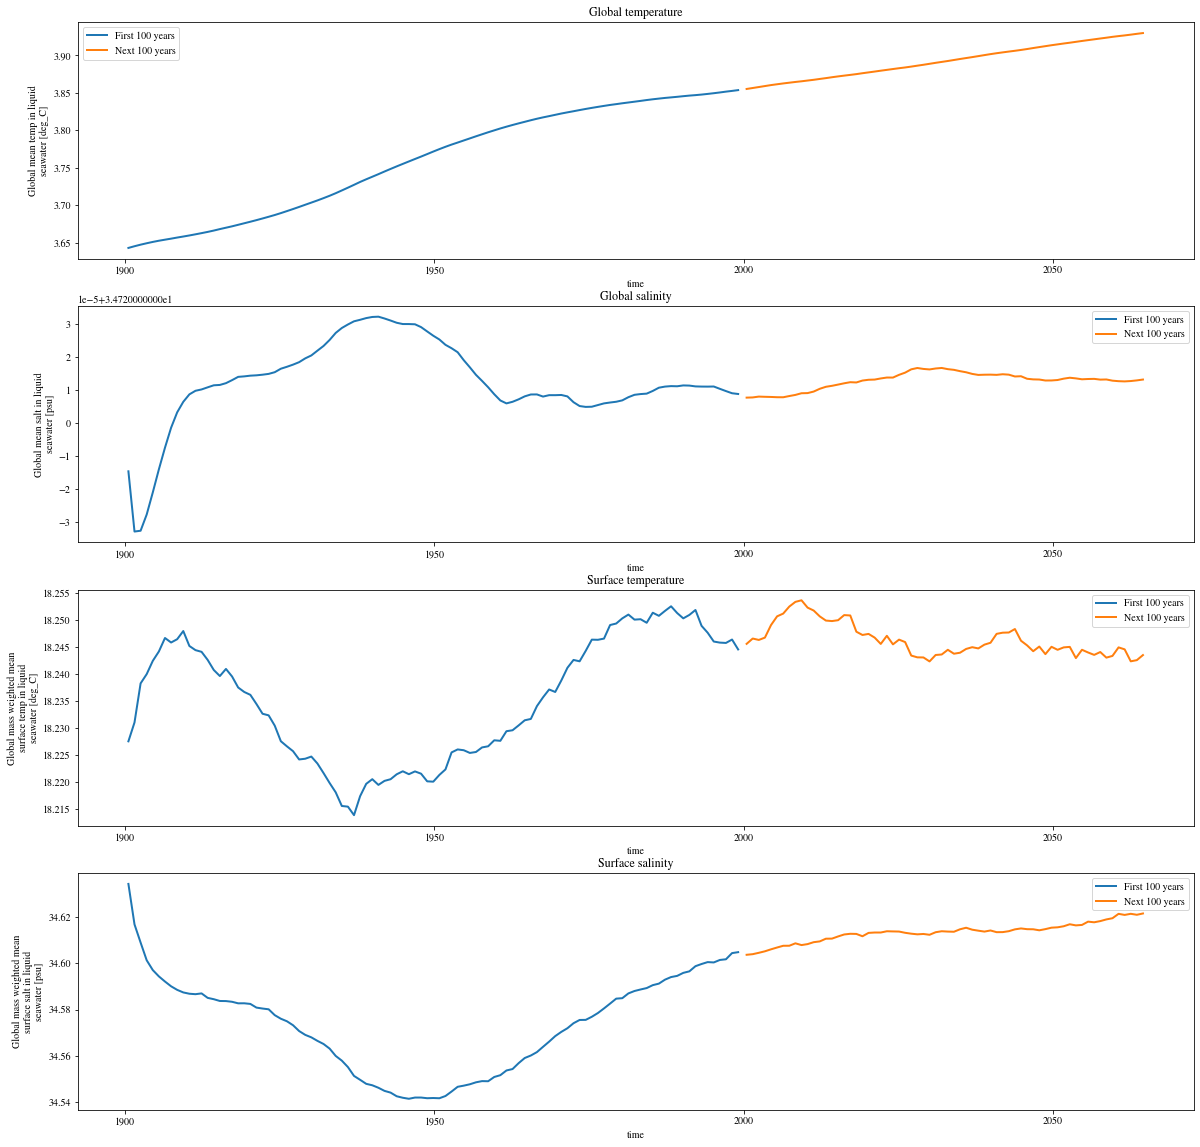

In [3]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l)#.sel(time = slice('2000-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

Text(0.5, 1.0, 'Drake Passage Transport')

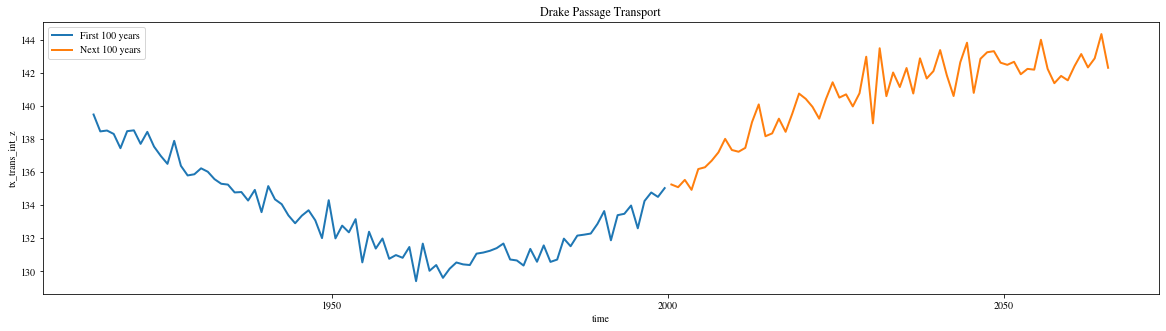

In [4]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

ncoarse = 12

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, start_time = '1915-01-01').sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot(label = name[i])
    plt.legend()

plt.title('Drake Passage Transport')

Text(0.5, 1.0, 'AABW Circulation')

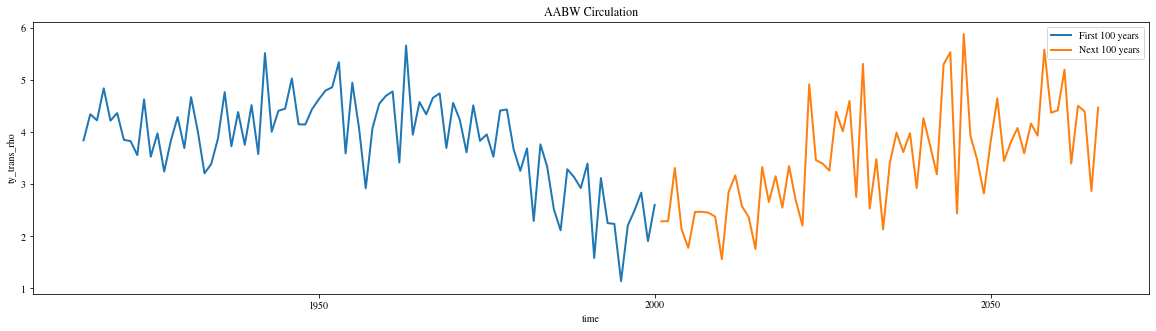

In [5]:
latitude = -45

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_aabw = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1915-01-01').sum(
            'grid_xt_ocean').sel(method = 'nearest', grid_yu_ocean = latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho = slice(1036.2, None)).min('potrho').resample(time = 'Y').mean()
    psi_aabw_sum.plot(label = name[i])
    plt.legend()

plt.title('AABW Circulation')

Text(0.5, 1.0, 'AMOC cell')

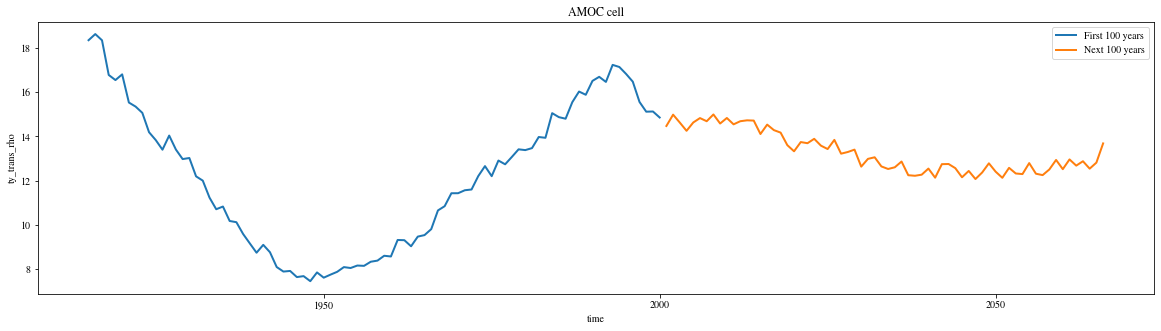

In [6]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1915-01-01').sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = name[i])
    plt.legend()

plt.title('AMOC cell')

It doesn't look like the base experiment has converged after 100 years, so we should continue running our extended experiment.

## Test

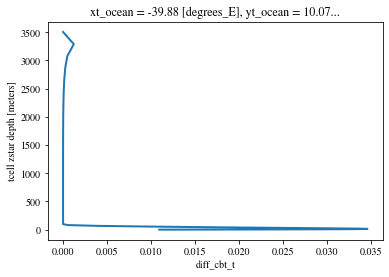

In [4]:
diff = cc.querying.getvar(expt[0], 'diff_cbt_t', session = session[0], start_time = '1915-01-01', end_time = '1915-12-31')
diff.sel(xt_ocean = -40, method = 'nearest').sel(yt_ocean = 10, method = 'nearest').mean('time').plot(y = 'st_ocean')

In [5]:
diff

,Array,Chunk
Bytes,6.95 GiB,1.24 MiB
Shape,"(24, 50, 1080, 1440)","(1, 25, 108, 120)"
Count,11522 Tasks,5760 Chunks
Type,float32,numpy.ndarray
